In [2]:
import pandas as pd
import numpy as np

df=pd.read_csv("./algo_data/vol_surfaces2.csv")
df['minute'] = pd.to_datetime(df['minute'])
df['minute'].apply(lambda x: x.tz).unique()
#for each row find 16:17:00 and compute years to maturity where maturity is 16:17:00 for each row

def get_years_to_maturity(row):
    maturity = pd.Timestamp(row['minute'].date(), tz=row['minute'].tz) + pd.Timedelta(hours=16, minutes=17)
    return (maturity - row['minute']).seconds / (365.25 * 24 * 60 * 60)

df['years_to_maturity'] = df.apply(get_years_to_maturity, axis=1)
df.loc[df['implied_spot'] <= .07, ['implied_spot', 'atm_vol', 'slope', 'quadratic_term', 'scaled_slope', 'scaled_quadratic']] = np.nan
df.loc[df['atm_vol'] <= .03, ['implied_spot', 'atm_vol', 'slope', 'quadratic_term', 'scaled_slope', 'scaled_quadratic']] = np.nan
# Forward fill the NaN values
df=df.ffill().infer_objects(copy=False)

/var/folders/c1/dv7w7b2x49j3spqsxnz6y_sw0000gn/T/ipykernel_82352/552555692.py:5: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df['minute'] = pd.to_datetime(df['minute'])


In [3]:

def apply_quadratic_volatility_model(strikes, spot, atm_vol, slope, quadratic_term, texp_years):
    """
    Apply the quadratic volatility model to new data points.
    
    Parameters:
        strikes (array-like): Array of strike prices.
        spot (float): Spot price.
        atm_vol (float): At-the-money volatility.
        slope (float): Slope of the linear term.
        quadratic_term (float): Coefficient of the quadratic term.
        texp_years (float): Time to expiration in years.
    
    Returns:
        array-like: Fitted volatilities for the given strikes.
    """
    #print(f"apply_quadratic_vol input sizes: strikes={strikes}, spot={len(spot)}, atm_vol={len(atm_vol)}, slope={len(slope)}, quadratic_term={len(quadratic_term)}, texp_years={len(texp_years)}")
    log_strikes = np.log(strikes) - np.log(spot)
    fitted_vols = atm_vol + slope * log_strikes + quadratic_term * log_strikes**2
    #fitted_vols = atm_vol + (slope / np.sqrt(texp_years)) * log_strikes + quadratic_term * log_strikes**2
    fitted_vols= np.clip(fitted_vols, .05,.4)
    return fitted_vols


In [4]:

import gymnasium as gym  # ✅ Use gymnasium instead of gym
import numpy as np
import pandas as pd
from gymnasium import spaces
from copy import deepcopy
import py_vollib_vectorized

class SimEnv(gym.Env):
    """
    Custom Options Trading Environment for Reinforcement Learning.
    """
    def __init__(self, df):
        super(SimEnv, self).__init__()
        
        # Market Data
        self.df = df
        self.df_today = None
        
        # Index Tracking
        self.global_index = 0
        self.daily_index = 0
        self.start_index = 0
        self.max_steps = 180  # Max steps per episode

        # Trading Variables
        self.position = 0
        self.entry_price = 0
        self.position_open_time = None

        # Capital & PnL
        self.capital = 100
        self.pnl = 0
        self.position_value = 0

        # Episode State
        self.done = False
        self.current_row = None

        # Action & Observation Space
        self.action_space = spaces.Discrete(3)  # 0: Hold, 1: Open, 2: Close
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(11,), dtype=np.float32)

    def __init__(self, env_config):
        super(SimEnv, self).__init__()
        
        # ✅ Read `df` from `env_config`
        self.df = env_config.get("df")
        
        # ✅ Ensure df is provided
        if self.df is None:
            raise ValueError("Error: `df` must be provided in env_config!")
        
        # ✅ Initialize other attributes
        self.df_today = None
        self.global_index = 0
        self.max_steps = 180  # Max steps per episode
        self.capital=100

        self.position = 0
        self.entry_price = 0
        self.pnl = 0
        self.done = False
        self.current_row = None
        
        self.action_space = spaces.Discrete(3)  # 0: Hold, 1: Open, 2: Close
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(11,), dtype=np.float32)

    def reset(self, seed=None):
        """ Reset environment and start a new episode. """
        self.global_index = self.pick_episode_start()
        self.daily_index = self.df_today.index.get_loc(self.global_index)
        self.start_index = self.global_index
        self.done = False
        self.position = 0
        self.pnl = 0

        # Compute daily straddle prices before trading starts
        straddle_prices = self.compute_daily_atm_straddle_prices()
        self.df_today["daily_straddle_prices"] = straddle_prices
        self.df_today["open_straddle_pnl"] = 0

        obs = self._get_state()  # Observation (state)
        action_mask = self.compute_action_mask()  # ✅ Compute action mask for valid actions
        info = {"action_mask": action_mask}  # ✅ Include action mask in `info`

        return obs, info  # ✅ Must return a tuple (obs, info)

    def _get_state(self):
        """ Returns the current state as a NumPy array. """
        row = self.df.iloc[self.global_index]
        steps_taken = self.global_index - self.start_index
        steps_remaining = self.max_steps - steps_taken
        
        state = np.array([
            row['implied_spot'],  # Current spot price
            row['atm_vol'],  # ATM implied volatility
            row['scaled_slope'],  # Volatility skew slope
            row['scaled_quadratic'],  # Volatility skew curvature
            steps_taken,  # How many steps taken in this episode
            steps_remaining,  # Steps remaining before timeout
            self.position,  # Position status (0: no position, >0: position held)
            int(self.position!=0),  # binary state to make it sumpler
            self.pnl,  # Cumulative PnL
            self.df_today["daily_straddle_prices"].loc[self.global_index],  # Current straddle price
            self.df_today["open_straddle_pnl"].loc[self.global_index]  # PnL from position
        ], dtype=np.float32)

        return state

    def compute_action_mask(self):
        """ Computes an action mask where invalid actions are marked as 0. """
        action_mask = np.array([1, 1, 1])  # Default: all actions allowed
        
        if self.position == 0:
            action_mask[2] = 0  # Can't close if no position is open
        else:
            action_mask[0] = 0  # Can't open a new position if one is already open
        
        return action_mask  # ✅ Masked actions for Rllib

    def step(self, action):
        """ Execute the selected action. """
        reward = 0.0
        allowed_actions = self.valid_actions()

        if action not in allowed_actions:
            if(action==0)and (self.position!=0):
                action=2
            elif(action==1)and (self.position==0):
                action=2
            else:
                action=2
     
     
            #return self._get_state(), reward, self.done, truncated, {"action_mask": self.compute_action_mask()}  # ✅ Return action mask

        if action == 0 and self.position == 0:  # Open position
            self.open_position()
            self.update_time_step(60)

        elif action == 1 and self.position != 0:  # Close position
            reward = self.df_today["open_straddle_pnl"].loc[self.global_index] - self.pnl
            self.pnl = self.df_today["open_straddle_pnl"].loc[self.global_index]
            self.position = 0
            self.done = True

        elif action == 2:  # Hold position
            if self.position !=0:
                reward = self.df_today["open_straddle_pnl"].loc[self.global_index] - self.pnl
                self.pnl = self.df_today["open_straddle_pnl"].loc[self.global_index]
            if self.position == 0:
                if self.global_index - self.start_index >= (self.max_steps-60):
                    self.done = True
            
            self.update_time_step(1)

        # End episode if time exceeds max steps
        if self.global_index - self.start_index >= self.max_steps:
            self.done = True

        return self._get_state(), reward, self.done, False, {"action_mask": self.compute_action_mask()}  # ✅ Return action mask

    def valid_actions(self):
        if self.position == 0:
            return [0, 2]
        else:
            return [1, 2]

    def render(self, mode="human"):
        """ Optional: Print state information for debugging. """
        print(f"Time: {self.df.iloc[self.global_index]['minute']}, Position: {self.position}, PnL: {self.pnl}")

    def close(self):
        pass
    def open_position(self):

        ivol = self.get_current_row()['implied_spot']
        texp = self.get_current_row()['years_to_maturity']
        spot=self.get_current_row()['implied_spot']
        #straddle_price_1 = self.price_one_day_straddle(texp, ivol)
        straddle_price=self.df_today['daily_straddle_prices'].loc[self.global_index]
        #print(f"straddle_price={straddle_price}")
        #print(f"straddle_price_1={straddle_price_1}")
        if (straddle_price == 0):
            print(f"eror: straddle_price={straddle_price}. at time={self.get_current_time()}")
        self.position = -self.capital / straddle_price
        #self.position_value = self.position * straddle_price
        self.strike=spot
        #spot_vols=self.compute_spot_vols(self.strike)
        self.straddle_prices=self.compute_straddle_prices(self.strike)
        self.df_today["open_straddle_prices"]=self.straddle_prices
        self.df_today["open_straddle_pnl"]=(self.df_today["open_straddle_prices"]- straddle_price)*self.position
        self.position_open_time = self.global_index
        return self.position*straddle_price


    def pick_random_day(self, burn_days=5):
        all_days = self.df['date'].unique()
        all_days = sorted(all_days)
        #print(f"all_days={all_days}")
        start_day = np.random.choice(all_days[burn_days:-1])
        return start_day

    def pick_random_timestep(self,df):
        all_times = df['minute'].apply(lambda x: x.time()).unique()
        all_times = sorted(all_times)
        latest_time = pd.Timestamp('12:45').time()
        earliest_time = pd.Timestamp('9:30').time()
        all_times = [x for x in all_times if x >= earliest_time and x <= latest_time]
        #print(f"all_times={all_times}")
        start_time = np.random.choice(all_times)
        return start_time

    def pick_episode_start(self):
        start_day = self.pick_random_day()
        self.df_today = self.df[self.df['date'] == start_day]
        self.df_today=deepcopy(self.df_today)
        start_time=self.pick_random_timestep(self.df_today)
        episode_start_index = self.df_today [(self.df_today['minute'].apply(lambda x: x.time()) == start_time)].index[0]
        #print(f"episode_start_index={episode_start_index}")
        
        #self.current_row = self.df.iloc[self.global_index]
        #self.df_today=self.select_todays_data()
        return episode_start_index
    
    

    
    def compute_spot_vols(self,strike):
        """
        Compute fitted volatilities for a range of strikes.
        
        Parameters:
            spot (float): Spot price.
            atm_vol (float): At-the-money
            slope (float): Slope of the linear term.
            quadratic_term (float): Coefficient of the quadratic term.
            texp_years (float): Time to expiration in years.    

        Returns:
            array-like: Fitted volatilities for a range of strikes.
        """
        spots=self.df_today['implied_spot']
        atm_vol=self.df_today['atm_vol']
        texp_years = self.df_today['years_to_maturity']
        slope=self.df_today['slope']
        quadratic_term=self.df_today['quadratic_term']
        #print(f"variable sizes: texp={texp_years.shape}, spot={spots.shape}, atm_vol={atm_vol.shape}, slope={slope.shape}, quadratic_term={quadratic_term.shape},strike={strike.shape}")
        vols = apply_quadratic_volatility_model(strike, spots, atm_vol, slope, quadratic_term, texp_years)
        #print(f"vols size={vols.shape}")
        return vols


    def compute_daily_atm_straddle_prices(self):
        """
        Compute straddle prices for a range of strikes.
        
        Parameters:
            spot (float): Spot price.
            atm_vol (float): At-the-money
            slope (float): Slope of the linear term.
            quadratic_term (float): Coefficient of the quadratic term.
            texp_years (float): Time to expiration in years.    

        Returns:
            array-like: Fitted volatilities for a range of strikes.
        """
        texp = self.df_today['years_to_maturity']
        spot = self.df_today['implied_spot']
        texp = self.df_today['years_to_maturity']
        vol=self.df_today['atm_vol']
        #print("variable sizes: ",texp.shape,spot.shape,vol.shape)
        straddle_prices = self.price_instrument('c', spot, spot, texp, vol) + self.price_instrument('p', spot, spot, texp, vol)

        return straddle_prices

    
    def compute_straddle_prices(self, strike):
        """
        Compute straddle prices for a range of strikes.:135

        
        Parameters:
            spot (float): Spot price.
            atm_vol (float): At-the-money
            slope (float): Slope of the linear term.
            quadratic_term (float): Coefficient of the quadratic term.
            texp_years (float): Time to expiration in years.    

        Returns:
            array-like: Fitted volatilities for a range of strikes.
        """
    
        texp = self.df_today['years_to_maturity']
        spot = self.df_today['implied_spot']
        vols=self.compute_spot_vols(strike)
        #print(f"variable sizes: texp={texp.shape}, spot={spot.shape}, vols={vols.shape}")
        #vols=apply_apply_quadratic_volatility_model(strike, spot, atm_vols, slopes, quadratic_terms, texp)
        straddle_prices = self.price_instrument('c', strike, spot, texp, vols) + self.price_instrument('p', strike, spot, texp, vols) 
        #print(f"straddle_prices={straddle_prices}")

        df_output=pd.DataFrame()
    
        df_output["spot"]=spot
        df_output["texp"]=texp
        df_output["vols"]=vols
        df_output["strike"]=strike
        df_output["straddle_prices"]=straddle_prices
        df_output.to_csv("straddle_prices.csv")

        return straddle_prices

    
    def update_time_step(self, minutes=1):
        self.global_index = min(self.global_index + minutes, self.df_today.index.max())

    
    def price_instrument(self, cp, strike, spot, texp, vol):
        #if self.debug:
        #    print(f"cp={cp}\n, strike={strike}\n, spot={spot}\n, texp={texp}\n, vol={vol}\n")
        #print(f"pricing_insturment sizes: cp={cp}, strike={strike.shape}, spot={spot.shape}, texp={texp.shape}, vol={vol.shape}")
        return py_vollib_vectorized.models.vectorized_black_scholes(cp, spot, strike, texp, 0, vol,return_as="numpy")

    
    def get_current_time(self):
        return self.df.iloc[self.global_index]['minute']
    

    def get_current_row(self):
        return self.df.iloc[self.global_index]

In [144]:
from stable_baselines3 import DQN
from stable_baselines3.common.env_checker import check_env
# Create & validate environment
env_config={"df": df}
env = SimEnv(env_config=env_config)
check_env(env)  # Check if it follows OpenAI Gym API

# Define the DQN model
model = DQN(
    "MlpPolicy",
    env,
    learning_rate=0.001,
    batch_size=32,
    buffer_size=10000,
    verbose=1,
    gradient_steps=1,
    max_grad_norm=10  # ✅ Prevents exploding gradients
)
# Train the model
model.learn(total_timesteps=500000)

# Save the trained model
model.save("dqn_options_trading2")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.75     |
|    ep_rew_mean      | 4.74     |
|    exploration_rate | 1        |
| time/               |          |
|    episodes         | 4        |
|    fps              | 262      |
|    time_elapsed     | 0        |
|    total_timesteps  | 15       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.38     |
|    ep_rew_mean      | -5.72    |
|    exploration_rate | 0.999    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 327      |
|    time_elapsed     | 0        |
|    total_timesteps  | 35       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.75     |
|    ep_rew_mean      | -0.971 

In [6]:
from stable_baselines3 import DQN

# ✅ Load the trained model
model = DQN.load("dqn_options_trading2")

# ✅ Initialize a new environment with the dataset
env = SimEnv(env_config={"df": df})  
obs, _ = env.reset()
pnls=[]
num_steps=[]
num_episodes=10000
# ✅ Run a single episode
for ind in range(num_episodes):
    done = False
    obs, info = env.reset()
    rewards=[]
    nstep=0
    while not done:
        action, _states = model.predict(obs)  # ✅ Get action from trained model
        obs, reward, done, truncated, _ = env.step(action)  # ✅ Step the environment
        rewards.append(reward)
        #env.render()  # ✅ Optional: Print state info
        nstep+=1

        if done:
            obs, _ = env.reset()  # ✅ Restart episode if done

    pnls.append(sum(rewards))
    num_steps.append(nstep)
print(f"average pnl={np.mean(pnls)}")
print(f"average steps={np.mean(num_steps)}")
print(f"median pnl={np.median(pnls)}")


average pnl=1.389654708513414
average steps=85.801
median pnl=7.347285014505321


In [1]:

import random
# ✅ Load the trained model
model = DQN.load("dqn_options_trading2")

# ✅ Initialize a new environment with the dataset
env = SimEnv(env_config={"df": df})  
obs, _ = env.reset()
pnls=[]
num_steps=[]
num_episodes=10000
# ✅ Run a single episode
for ind in range(num_episodes):
    done = False
    obs, info = env.reset()
    rewards=[]
    nstep=0
    while not done:
        action=random.choice([0,1,2])
        obs, reward, done, truncated, _ = env.step(action)  # ✅ Step the environment
        rewards.append(reward)
        #env.render()  # ✅ Optional: Print state info
        nstep+=1

        if done:
            obs, _ = env.reset()  # ✅ Restart episode if done

    pnls.append(sum(rewards))
    num_steps.append(nstep)
print(f"average pnl={np.mean(pnls)}")
print(f"average steps={np.mean(num_steps)}")
print(f"median pnl={np.median(pnls)}")

NameError: name 'DQN' is not defined

In [5]:
done=False
rewards=[]
while not done:
    action, _states = model.predict(obs)  # ✅ Get action from trained model
    obs, reward, done, truncated, _ = env.step(action)  # ✅ Step the environment
    #rewards.append(reward)
    env.render()  # ✅ Optional: Print state info
    rewards.append(reward)

    print(f"reward={reward}")
    print("sum rewards=",sum(rewards))
    nstep+=1

    if done:
        obs, _ = env.reset()  # ✅ Restart episode if done


NameError: name 'model' is not defined

Using 1000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


obs=[ 5.8385986e+02  1.5220688e-01 -1.0099972e-02  2.1913658e-01
  1.0000000e+00  1.7900000e+02  0.0000000e+00  0.0000000e+00
  0.0000000e+00  1.9406822e+00  0.0000000e+00]
[[ 1.71083037  1.7687769   1.76275019]
 [-0.05107348 -0.04988341 -0.05230335]
 [ 0.00696156  0.00676216  0.00712491]
 [-0.01553098 -0.015159   -0.015904  ]
 [-0.06277313 -0.07381081 -0.06565572]
 [ 0.06085847  0.0641298   0.06283818]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [-0.11135421 -0.10817087 -0.11397085]
 [ 0.          0.          0.        ]]


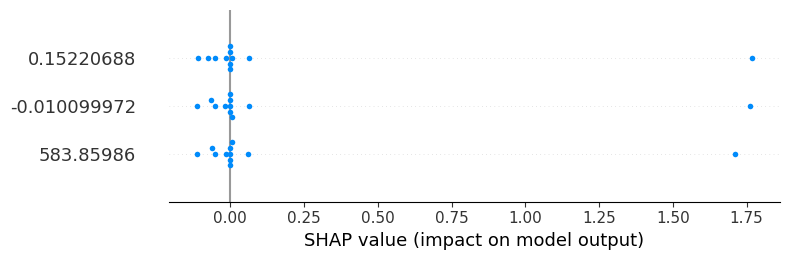

In [15]:
import shap
import torch

# ✅ Function to get Q-values from the trained DQN model
def get_q_values(obs):
    obs_tensor = torch.tensor(obs, dtype=torch.float32)
    with torch.no_grad():
        q_values = model.policy.q_net(obs_tensor).numpy()
    return q_values

obs_samples = np.array([env.reset()[0] for _ in range(1000)])
explainer = shap.KernelExplainer(get_q_values, obs_samples)
obs, _ = env.reset()
obs=env.step(2)[0]
print(f"obs={obs}")
shap_values = explainer.shap_values(obs)
print(shap_values)

# ✅ Visualize SHAP values
shap.summary_plot(shap_values, obs)


In [14]:
obs
model.policy.q_net(torch.tensor(obs, dtype=torch.float32).reshape(1, -1))
#get_q_values(obs)

tensor([[20.3162, 20.9106, 20.9054]], grad_fn=<AddmmBackward0>)

In [213]:
# ✅ Get SHAP values for a single observation
obs = env.reset()[0]
obs =env.step(2)[0]


In [16]:
shap_values = explainer.shap_values(obs)
print([x[0] for x in shap_values])
# ✅ Create a DataFrame for easy visualization
df_shap = pd.DataFrame({
    "Feature": ["implied_spot", "atm_vol", "scaled_slope", "scaled_quadratic", 
                "steps_taken", "steps_remaining", "position", "binary_position", 
                "pnl", "daily_straddle_price", "open_straddle_pnl"],  # Add feature names manually
    "SHAP Value": [x[0] for x in shap_values]  # Assuming this is for action 0
})
base_value = explainer.expected_value[0]  # Base Q-value for action 0
# ✅ Sort by importance
df_shap_sorted = df_shap.sort_values(by="SHAP Value", ascending=False)

print(df_shap_sorted)
print(f"base_value={base_value}")

print(f"sum of shap values={sum([x[0] for x in shap_values])}")
print(f"q_value={get_q_values(obs.reshape(1, -1))[0][0]}")
print(f"base_value+sum of shap values={base_value+sum([x[0] for x in shap_values])}")

[np.float64(1.7108303741772992), np.float64(-0.051073478762304614), np.float64(0.006961558453244773), np.float64(-0.015530984846740446), np.float64(-0.06277313154543655), np.float64(0.060858466100699435), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(-0.11135421207744889), np.float64(0.0)]
                 Feature  SHAP Value
0           implied_spot    1.710830
5        steps_remaining    0.060858
2           scaled_slope    0.006962
6               position    0.000000
7        binary_position    0.000000
8                    pnl    0.000000
10     open_straddle_pnl    0.000000
3       scaled_quadratic   -0.015531
1                atm_vol   -0.051073
4            steps_taken   -0.062773
9   daily_straddle_price   -0.111354
base_value=17.97791812419893
sum of shap values=1.537918591499313
q_value=19.515836715698242
base_value+sum of shap values=19.515836715698242


In [17]:
import numpy as np
import lime
import lime.lime_tabular

In [18]:
def get_q_values(states):
    """
    Function to get Q-values from the trained DQN model.
    
    Args:
        states: np.array of state observations.

    Returns:
        Q-values for all actions (shape: [num_samples, num_actions])
    """
    states = np.array(states).reshape(-1, env.observation_space.shape[0])  # Ensure correct shape
    q_values = model.predict(states, deterministic=True)[0]  # Get Q-values
    return q_values  # LIME requires output shape (num_samples, num_actions)

In [36]:
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array([env.reset()[0] for _ in range(100)]),  # Sample background states
    mode="regression",  # Q-values are continuous, so use regression mode
    feature_names=["implied_spot", "atm_vol", "scaled_slope", "scaled_quadratic",
                   "steps_taken", "steps_remaining", "position", "binary_position",
                   "pnl", "daily_straddle_price", "open_straddle_pnl"],  # Adjust to match state features
    discretize_continuous=False  # RL features are continuous
)

In [37]:
obs, _ = env.reset()  # Get a starting state
action = model.predict(obs.reshape(1, -1), deterministic=True)[0]  # Get action
action=0
print("action=",action)
exp = explainer.explain_instance(
    obs,  # The state to explain
    get_q_values,  # Function that returns Q-values
    num_features=5  # Show top 5 most important features
)

exp.show_in_notebook()  # Show LIME explanation

action= 0


In [21]:
exp.as_list()  # Get explanation as a list

[('pnl', -0.25093095888501527),
 ('open_straddle_pnl', 0.20991664526208317),
 ('daily_straddle_price', 0.1786221591116513),
 ('position', -0.1625771155999637),
 ('steps_taken', 0.07118189890903101)]

In [38]:
def get_q_for_action(state, action):
    """
    Function to get the Q-value for a specific action.

    Args:
        state (np.array): The current state observation.
        action (int): The action index (0: Hold, 1: Open, 2: Close).

    Returns:
        The Q-value corresponding to the given action.
    """
    state = np.array(state).reshape(1, -1)  # Ensure correct shape
    q_values = model.predict(state, deterministic=True)[0]  # Get Q-values
    return q_values[action]  # Extract Q-value for the specified action

In [42]:
# Choose an action to analyze (e.g., 0: Hold, 1: Open, 2: Close)
specific_action = 2  # Example: Explain why the model gives a Q-value for "Close"


def lime_q_function(states):
    """
    Modified function to handle both batch and single-state predictions.
    
    Args:
        states (np.array): A batch of state observations.

    Returns:
        np.array: Q-values for the specified action, for each state.
    """
    states = np.array(states).reshape(len(states), -1)  # Ensure correct shape
    q_values = model.predict(states, deterministic=True)[0]  # Get Q-values

    # ✅ Ensure q_values is 2D
    if len(q_values.shape) == 1:  
        return q_values[specific_action]  # Return Q-value directly for a single state
    else:
        return q_values[:, specific_action]  # Extract Q-value for batch inputs


# Run LIME for the chosen action
exp = explainer.explain_instance(
    obs, 
    lime_q_function,  # ✅ Explains the Q-value of the chosen action
    num_features=5
)

# Show explanation
exp.show_in_notebook()

IndexError: invalid index to scalar variable.

In [40]:
obs

array([ 5.9949146e+02,  1.2738542e-01, -5.7983799e-03,  4.7596940e-01,
        0.0000000e+00,  1.8000000e+02,  0.0000000e+00,  0.0000000e+00,
        0.0000000e+00,  1.4792688e+00,  0.0000000e+00], dtype=float32)